# Regression Models


### Motivation

Why are we learning linear regression?

* easy to use - does not require lots of fine tuning
* runs fast
* highly interpretable

### Python Libraries

* [Statsmodels](http://www.statsmodels.org/stable/index.html):nice for linear modeling
* [scikit-learn](http://scikit-learn.org/stable/): more functionality for machine learning in general

### Introduction
Sir Francis Galton, a cousin of James Darwin, examined the relationship between the height of children and their parents towards the end of the 19th century. He coined the terms "regression" and "correlation".

#### Questions to consider
* Use parent's heights to predict childrent's heights.
* Find a concise relationship between parents' and children's heights.
* Investigate variations in children's heights that appears unrelated to parent's heights.
* Quantify what impact genotype information has beyond parental height in explaining child height.
* Figure out what assumptions are needed to generilise findings beyond the data in question.


In [115]:
import csv
import requests 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("GnBu_d")
import warnings
warnings.filterwarnings('ignore')

In [116]:
# Get data from URL and load into a dataframe
url = "http://www.math.uah.edu/stat/data/Galton.csv"
with requests.Session() as s:
    download = s.get(url)
    decoded_content = download.content.decode('utf-8')
 
data_iter = csv.reader(decoded_content.splitlines(), delimiter=',')
data = [data for data in data_iter]
#print(data) 
df = pd.DataFrame(data[1:]) #skip first line with the titles
df.columns = data[0] #first line of CSV has col names
#print(df)
print(df.head())
print("\n", df.dtypes)
print("\n", df.describe())

  Family Father Mother Gender Height Kids
0      1   78.5     67      M   73.2    4
1      1   78.5     67      F   69.2    4
2      1   78.5     67      F     69    4
3      1   78.5     67      F     69    4
4      2   75.5   66.5      M   73.5    4
('\n', Family    object
Father    object
Mother    object
Gender    object
Height    object
Kids      object
dtype: object)
('\n',        Family Father Mother Gender Height Kids
count     898    898    898    898    898  898
unique    197     34     29      2     65   12
top       185     70     65      M     65    5
freq       15    131    133    465     61  140)


In [117]:
#convert the cells of interest to numeric datatype
df[['Father', 'Mother', 'Height', 'Kids']] = df[['Father', 'Mother', 'Height', 'Kids']].apply(pd.to_numeric)
print("\n", df.describe(include=['number']))
#print(df)
#add column for mean parents height
df['Mean_Parents'] = (df['Father'] + df['Mother'])/2.
print("\n", df.describe(include=['number']))


('\n',            Father      Mother      Height        Kids
count  898.000000  898.000000  898.000000  898.000000
mean    69.232851   64.084410   66.760690    6.135857
std      2.470256    2.307025    3.582918    2.685156
min     62.000000   58.000000   56.000000    1.000000
25%     68.000000   63.000000   64.000000    4.000000
50%     69.000000   64.000000   66.500000    6.000000
75%     71.000000   65.500000   69.700000    8.000000
max     78.500000   70.500000   79.000000   15.000000)
('\n',            Father      Mother      Height        Kids  Mean_Parents
count  898.000000  898.000000  898.000000  898.000000     898.00000
mean    69.232851   64.084410   66.760690    6.135857      66.65863
std      2.470256    2.307025    3.582918    2.685156       1.75101
min     62.000000   58.000000   56.000000    1.000000      62.00000
25%     68.000000   63.000000   64.000000    4.000000      65.50000
50%     69.000000   64.000000   66.500000    6.000000      66.75000
75%     71.000000   65.

Following Galton's methodology we will adjust the female heights so that so that both average female and male height are equal.

('\n',            Father      Mother      Height        Kids  Mean_Parents  \
count  898.000000  898.000000  898.000000  898.000000     898.00000   
mean    69.232851   64.084410   66.760690    6.135857      66.65863   
std      2.470256    2.307025    3.582918    2.685156       1.75101   
min     62.000000   58.000000   56.000000    1.000000      62.00000   
25%     68.000000   63.000000   64.000000    4.000000      65.50000   
50%     69.000000   64.000000   66.500000    6.000000      66.75000   
75%     71.000000   65.500000   69.700000    8.000000      67.50000   
max     78.500000   70.500000   79.000000   15.000000      72.75000   

       Adj_Height  
count  898.000000  
mean    69.233715  
std      2.595853  
min     60.000000  
25%     67.500000  
50%     69.120000  
75%     71.000000  
max     79.000000  )


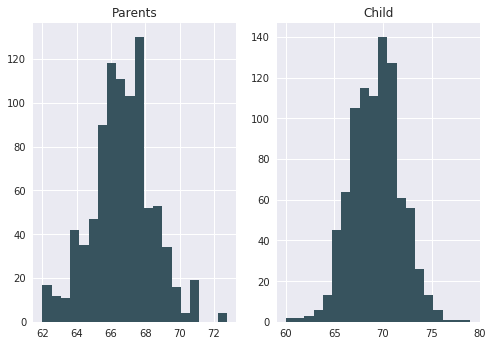

In [118]:
#adjust female height by multiplying by 1.08
# 1st alternative
def adjust_height(c):
    if c['Gender'] == 'F':
        return c['Height'] * 1.08
    else:
        return c['Height']

#%timeit 
df['Adj_Height'] = df.apply(adjust_height,axis=1)
#print("\n", df.describe(include=['number']))
# 2nd alternative (faster)
#%timeit 
df['Adj_Height'] = np.where(df['Gender']=='F', df['Height'] * 1.08, df['Height'])  
print("\n", df.describe(include=['number']))


#plot the two distributions
f, (ax1,ax2) = plt.subplots(1,2)
ax1.hist(df['Mean_Parents'],20)
ax1.set_title('Parents')
ax2.hist(df['Adj_Height'],20)
ax2.set_title('Child')

#### Finding the middle via least squares

Considering only the children's heights, how could one describe the "middle"?

Let $Y_i$ be the height of child $i$ for $i= 1, ..., n$. Define the middle as the value $\mu$ that minimises $$\sum^n_{i=1} \left( Y_i - \mu\right)^2$$

This is the physical center of mass of the histogram, and $\mu = \bar{Y}$.

In [149]:
from ipywidgets import interact

from  bokeh.models.sources import ColumnDataSource
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

mu = 50
source = ColumnDataSource(data=dict(mu=[mu,mu], h=df['Adj_Height']))

hist, edges = np.histogram(df['Adj_Height'], density=True, bins=20)
p = figure(title='Childrens height distribution', plot_height=300, plot_width=600, y_range=(-.1,0.3),x_axis_label='child')
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")

r = p.line('mu', [0,0.25], color="#9b0f0f",source=source, line_width=3)

def calc_mse_s(mi,h):    
    mse = ((h-mi).pow(2)).mean()  
    return mse
        

def update( m=60):    
    r.data_source.data['mu'] = [m,m]
    #gi.data_source.data['ys'] = [ [a+b*entry[0],entry[1]] for entry in zip(x_n,y_n)] 
    mse = calc_mse_s(m,r.data_source.data['h'] )
    p.title.text='Childrens height distribution (mu= %.3f, MSE = %.3f)'%(m, mse)
    push_notebook()
    
    
show(p, notebook_handle=True)
interact(update,  m=(60,80))

#manipulate to find center of mass , slider controls position of bar, top position of mi kai MSE


Loading BokehJS ...

<function __main__.update>

The empirical mean is the least squares solution for minimising the sum of squared deviations:

$\begin{align} 
\sum_{i=1}^n (Y_i - \mu)^2 & = \
\sum_{i=1}^n (Y_i - \bar Y + \bar Y - \mu)^2 \\ 
& = \sum_{i=1}^n (Y_i - \bar Y)^2 + \
2 \sum_{i=1}^n (Y_i - \bar Y)  (\bar Y - \mu) +\
\sum_{i=1}^n (\bar Y - \mu)^2 \\
& = \sum_{i=1}^n (Y_i - \bar Y)^2 + \
2 (\bar Y - \mu) \sum_{i=1}^n (Y_i - \bar Y)  +\
\sum_{i=1}^n (\bar Y - \mu)^2 \\
& = \sum_{i=1}^n (Y_i - \bar Y)^2 + \
2 (\bar Y - \mu)  (\sum_{i=1}^n Y_i - n \bar Y) +\
\sum_{i=1}^n (\bar Y - \mu)^2 \\
& = \sum_{i=1}^n (Y_i - \bar Y)^2 + \sum_{i=1}^n (\bar Y - \mu)^2\\ 
& \geq \sum_{i=1}^n (Y_i - \bar Y)^2 \
\end{align} $

However, we would like to explain the variance of children's data with the parents heights.
With a simple scatter plot we observe that there is some underlying linear relaship between these two variables:

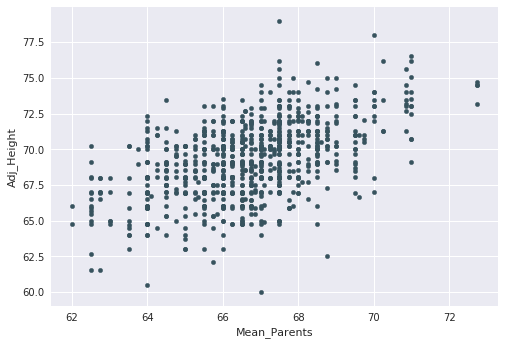

In [120]:
df.plot(kind='scatter', x='Mean_Parents', y='Adj_Height');

## Notation


We will use capital letters for conceptual values of the variables and lowercase for realised ones:
> * $X_i$ is a conceptual random variable
> * $x$ is a realised variable (the number we plug in)


#### Empirical Mean: $$\bar{X} = \frac{1}{n} \sum_{i=1}^{n}{ X_i}$$

Recall from previous section that the empirical mean is the least squares solution for minimising $$\sum_{i=1}^n \left(X_i - \mu \right)^2$$


#### Empirical Variance: 
$$ S^2 = \frac{1}{n-1} \sum_{i=1}^{n}{ \left( X_i - \bar{X} \right)^2  } = \frac{1}{n-1} \left(\sum_{i=1}^{n}{  X_i^2 - n\bar{X}^2  } \right) $$

#### Empirical Standard Deviation:
$$ S = \sqrt{S^2}$$

Notice that standard deviation is expressed in the same units as $X_i$.

**Scaling** : Rescaling the data, $\frac{X_i}{S}$, to have empirical standard deviation $1$.

#### Normalisation:

Centered and scaled data, defined by: $$ Z_i = \frac{X_i-\bar{X}}{S}$$ have empirical mean $0$ and empirical standard deviation $1$.




For pairs of datapoints, $\left( X_i, Y_i \right)$:
#### Empirical Covariance:

$$ Cov(X, Y) = 
\frac{1}{n-1}\sum_{i=1}^n (X_i - \bar X) (Y_i - \bar Y)
= \frac{1}{n-1}\left( \sum_{i=1}^n X_i Y_i - n \bar X \bar Y\right) $$

#### Correlation:

$$ Cor(X, Y) = \frac{Cov(X, Y)}{S_x S_y}, $$
where $S_x$ and $S_y$ are estimates of standard deviations for the $X$ and $Y$ observations, respectively.


* $Cor(X, Y) = Cor(Y, X)$
* $-1 \leq Cor(X, Y) \leq 1$
* $Cor(X,Y) = 1$ and $Cor(X, Y) = -1$ only when the $X$ or $Y$ observations fall perfectly on a positive or negative sloped line, respectively.
* $Cor(X, Y)$ measures the strength of the linear relationship between the \(X\) and \(Y\) data, with stronger relationships as \(Cor(X,Y)\) heads towards -1 or 1.</li>
* $Cor(X, Y) = 0$ implies no linear relationship. 


## Linear Regression



#### Regression through the origin

Suppose $X_i$ are the parents' heights (**predictor**) and $Y_i$ the children's heights (**response**). We assume that the children's heights may be explained by the parent's height.

We would like to identify the **slope** $\beta$ that minimises 
$$ \sum_{i=1}^n \left( Y_i - X_i \beta \right)^2 $$

This is exactly using the origin as a pivot point picking the line that minimises the sum of the squared vertical distances of the points to the line.

Here it is easy to see that for
$$ min_\beta \sum(Y_i - \beta X_i)^2 = \sum Y_i^2 - 2\beta\sum X_iY_i + \beta^2\sum X_i^2,$$

we derive the condition $$- 2\sum X_iY_i + 2\hat{\beta}\sum X_i^2=0$$ which results in
$$\hat{\beta}= \frac{\sum X_i Y_i}{\sum X_i^2}$$.

Let us first consider a simple contrived example:

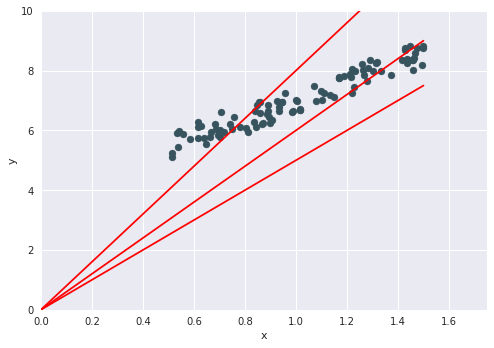

In [121]:
#create random points 
x = np.random.rand(100) + 0.5
a =  np.random.rand(100)+3.5
b = 3 
y = b * x + a
plt.scatter(x,y)
plt.plot([0,1.5],[0,8*1.5] ,'r')
plt.plot([0,1.5],[0,5*1.5] ,'r')
plt.plot([0,1.5],[0,6*1.5] ,'r')
plt.xlim([0,1.75])
plt.ylim([0,10])
plt.xlabel('x')
plt.ylabel('y')

Substract the means so that the origin is the mean of parent and children's heights (this is called **centering**)

In [150]:
x_n = x - np.mean(x)
y_n = y - np.mean(y)


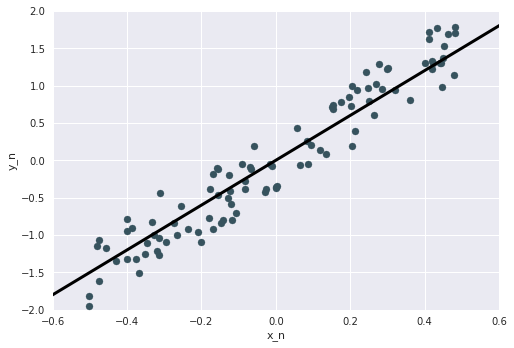

In [123]:
plt.scatter(x_n,y_n)
plt.xlim([-0.6,.6])
plt.ylim([-2.,2])
plt.xlabel('x_n')
plt.ylabel('y_n')
plt.plot([-1.,1],[-3,3],'k',lw=3)


In [148]:
from ipywidgets import interact

from  bokeh.models.sources import ColumnDataSource
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

x_i = np.array([np.min(x_n),np.max(x_n)])
y_i = x_i
b = 1.
source = ColumnDataSource(data=dict(x_i=x_i, y_i=y_i))

p = figure(title='Regression through the origin', plot_height=300, plot_width=600, y_range=(-5,5),x_axis_label='x', y_axis_label='y')
p.circle(x_n, y_n, radius=0.01, color="#11535c", fill_alpha=0.6, line_color=None)
r = p.line('x_i', 'y_i', color="#2A2E33",source=source, line_width=3,legend="y=x*b")

xs = [[entry, entry] for entry in x_n]

ys = [[b*entry[0],entry[1]] for entry in zip(x_n,y_n)] 

source2 = ColumnDataSource(data=dict(xs=xs, ys=ys))
gi = p.multi_line('xs','ys',source=source2 ,line_width=2., color="#9b0f0f" )

def calc_mse(xs, ys, a, b):
    mse = np.sum((ys - (a+b*xs))**2)/np.size(ys)    
    return mse
        

def update(  b=1): 
    a=0
    r.data_source.data['y_i'] = (b * x_i )
    gi.data_source.data['ys'] = [ [b*entry[0],entry[1]] for entry in zip(x_n,y_n)] 
    mse = calc_mse(x_n,y_n,a,b)
    p.title.text='Regression through the origin (b = %.3f, MSE = %.3f)'%(b, mse)
    push_notebook()
    
    
show(p, notebook_handle=True)
interact(update, b=(-6.,6.))




Loading BokehJS ...

<function __main__.update>

#### With scipy (stats)

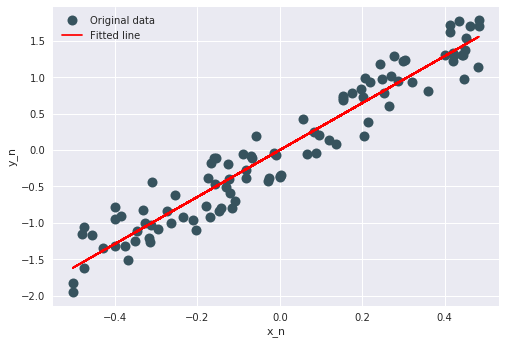

Slope = 3.223
MSE = 0.070


In [125]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(x_n,y_n)
plt.plot(x_n, y_n, 'o', label='Original data', markersize=10)
plt.plot(x_n, slope*x_n + intercept, 'r', label='Fitted line')
plt.xlabel('x_n')
plt.ylabel('y_n')
plt.legend()
plt.show()

print('Slope = %.3f' %slope)
#print('Intercept = %.3f' %intercept)
print('MSE = %.3f'%calc_mse(x_n,y_n,intercept,slope))

#### With scipy (statsmodels)



In [143]:
from statsmodels.formula.api import ols
data = pd.DataFrame({'x_n': x_n, 'y_n': y_n})
model = ols("y_n ~ x_n", data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    y_n   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     1241.
Date:                Wed, 10 May 2017   Prob (F-statistic):           1.89e-57
Time:                        07:04:38   Log-Likelihood:                -9.1897
No. Observations:                 100   AIC:                             22.38
Df Residuals:                      98   BIC:                             27.59
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     6.8e-16      0.027   2.54e-14      1.0

#### With numpy

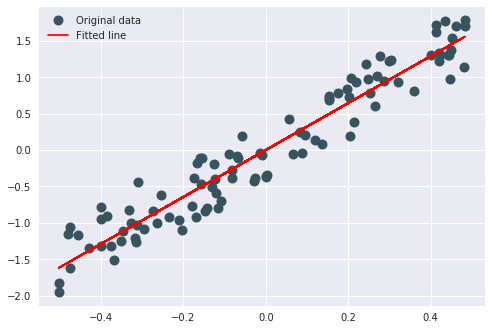

Slope = 3.223
MSE = 0.070


In [127]:

# rewrite as y = Ap , with A = [[x 1]] and p = [[m], [c]] and solve for p

A = np.vstack([x_n, np.zeros(len(x_n))]).T

m, c = np.linalg.lstsq(A, y_n)[0]

plt.plot(x_n, y_n, 'o', label='Original data', markersize=10)
plt.plot(x_n, m*x_n + c, 'r', label='Fitted line')
plt.legend()
plt.show()



print('Slope = %.3f' %m)
#print('Intercept = %.3f' %c)
print('MSE = %.3f'%calc_mse(x_n,y_n,c,m))

#### With sklearn

('Coefficients:', array([[ 3.22260395]]))


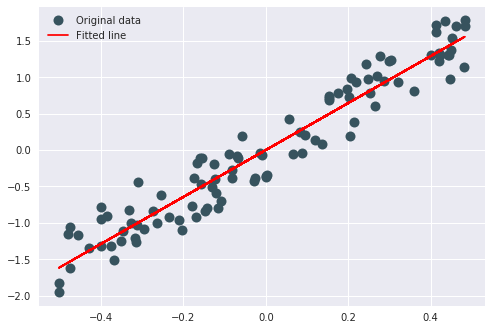

Slope = 3.223
MSE = 0.070


In [128]:
from sklearn import linear_model

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_n.reshape(-1,1), y_n.reshape(-1,1))

# The coefficients
print('Coefficients:', regr.coef_)
# The mean squared error
#print("Mean squared error: %.2f"
#      % np.mean((regr.predict(x_n.reshape(-1,1)) - y_n.reshape(-1,1)) ** 2))
# Explained variance score: 1 is perfect prediction
#print('Variance score: %.2f' % regr.score(x_n.reshape(-1,1), y_n.reshape(-1,1)))

sl  = regr.coef_[0][0]
inter = regr.intercept_[0]

plt.plot(x_n, y_n, 'o', label='Original data', markersize=10)
plt.plot(x_n, sl*x_n + inter, 'r', label='Fitted line')
plt.legend()
plt.show()



print('Slope = %.3f' %sl)
#print('Intercept = %.3f' %c)
print('MSE = %.3f'%calc_mse(x_n,y_n,inter,sl))


### Ordinary Least Squares (OLS)

We would like to find the best line </li>

Child's Height = $\beta_0$ + $\beta_1 $ Parent's Height

Using least squares
$$ \sum_{i=1}^n \{Y_i - (\beta_0 + \beta_1 X_i)\}^2.$$

The least squares fit to the line $Y = \beta_0 + \beta_1 X$ through the data pairs $(X_i, Y_i)$, with $Y_i$ the outcome results in $Y = \hat{\beta_0} + \hat{\beta_1} X$, with
$$\hat{\beta_1} = Cor(Y,X) \frac{S_Y}{S_X}$$ and
$$ \hat{\beta_0} = \bar{Y} - \hat{\beta_1} \bar{X}.$$

$\beta_0$, the **intercept** and $\beta_1$, the **slope**, are the model coefficients.

Obviously the line passes through $(\bar{X}, \bar{Y})$, so is equivalent with the line obtained from regression throught the origin of centered data.

The slope of the regression line with $X$ as the outcome and $Y$ as the predictor is $Cor(Y, X) \frac{Sd(X)}{ Sd(Y)}!!!$

For **normalised data**, the slope is $Cor(Y, X).$


3.22260395303
3.78038177821


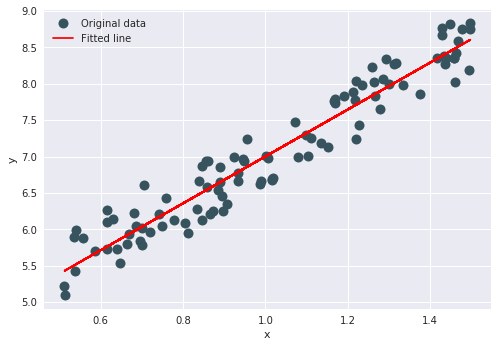

In [129]:
from scipy.stats.stats import pearsonr
cor_YX, p_val = pearsonr(y, x)
b1  = cor_YX*np.std(y)/np.std(x)
print b1#(r"$\hat{\beta_1} = %.3f$"%b1)
b0 = np.mean(y)-b1*np.mean(x)
print b0

#plot data points and fitted line
plt.plot(x, y, 'o', label='Original data', markersize=10)
plt.plot(x, b1*x + b0, 'r', label='Fitted line')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Let's try to reverse the role of the predictor and the outcome:

0.287599572269
-1.01297952359


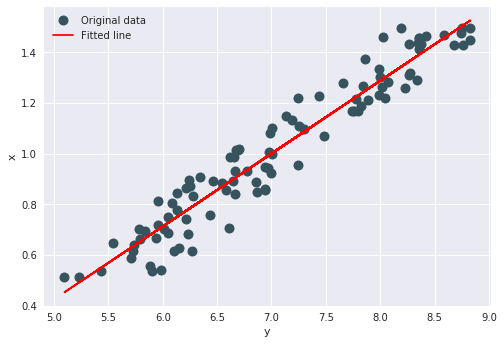

In [130]:
# reverse outcome/ predictor relationship
b1  = cor_YX*np.std(x)/np.std(y)
print b1#(r"$\hat{\beta_1} = %.3f$"%b1)
b0 = -b1*np.mean(y)+np.mean(x)
print b0


#plot data points and fitted line
plt.plot(y, x, 'o', label='Original data', markersize=10)
plt.plot(y, b1*y + b0, 'r', label='Fitted line')
plt.xlabel('y')
plt.ylabel('x')
plt.legend()
plt.show()

***Notice the different coefficients obtained for the reversed model!!!***

## Interpreting Model Coefficients

How do we interpret the $\beta_1$ coefficient?
* A unit increase in parent's height is **associated with** $\beta_1$ units increase in children's height.
* A decrease would be designated by a **negative** coefficient $\beta_1$.

### Excersises

- #### Galton's parents'-children's heights:
For the "galton.csv" dataset:
 * Create additional columns with centred versions of the columns "Adj_Heights" and "Mean_Parents" 
 * Perform a regression through the origin employing the newly created columns.
 * Plot the data and the fitted line.
 * Calculate the Mean Squared Error between the predicted model and the fitted data.
 * Perform a regression on the uncentered data and compare the slope with the previously identified one.
 * Plot the uncentered data and the predicted model.
 * Calculate the MSE.
 * Calculate the slope and variance using the aforementioned correlation formulas.
 * Reverse the role of the predictor/outcome and try to explain the parents' height with the children's height.
 * Compare the model coefficients with the previously identified ones.
 * Now, add two further columns with normalised data.
 * Perform linear regression considering the children's heights as outcome.
 * Perform linear regression considering the parents' heights as outcome.
 * Compare the slopes.

## How Well Does the Model Fit the data?

## Residuals

Represent variation left unexplained by the fitted model - the vertical distances from the fitted line to the data points.

Assuming the underlying model that the data follows $$Y_i = \beta_0 + \beta_1 X_i + \epsilon_i,$$
where $\epsilon_i \sim N(0,\sigma^2)$, the predicted outcome $\hat{Y_i}$ at the predictor value $X_i$ will be $$\hat{Y_i} = \hat{\beta_0} + \hat{\beta_1} X_i$$

The residual between the observed and the predicted outcome $$e_i = Y_i -\hat{Y_i}.$$

Least squares minimises the squared vertical distances, so in essence minimises $\sum^n_{i=1}e^2_i.$

The $e_i$ may be thought as estimates of the $\epsilon_i$.

#### Properties of the residuals

* $E[e_i] = 0$
* Useful for diagnosing poor model fit (residual plots)
* May be thought as the outcome $Y$ with the linear association with the predictor $X$ having been removed.

So one can differentiate residual variation (variation after removing the linear relaship with the predictor) from systematic variation (variation explained by the regression model)




In [131]:
#with numpy
y_hat1 = m*x_n + c


#with scipy - stats
y_hat2 = slope*x_n + intercept

#with scipy - statsmodels

y_hat3 = model.predict(x_n)

#with sklearn

y_hat4 = regr.predict(x_n.reshape(-1,1))

res1 = y_n - y_hat1
res2 = y_n - y_hat2
res3 = y_n - y_hat3
res4 = y_n - y_hat4.reshape(-1,)


### Residual Plot

(100,)


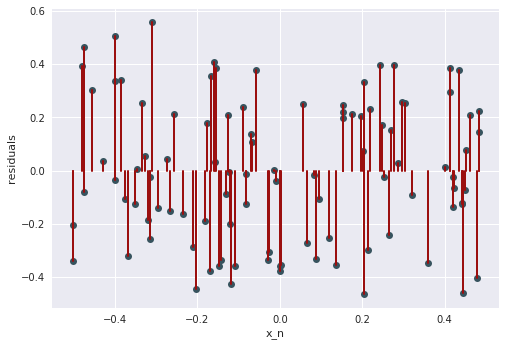

In [132]:
print x_n.shape
plt.plot(x_n,res1,'o')

for i in xrange(len(x_n)):
    plt.plot([x_n[i],x_n[i]] , [res1[i], 0],color="#9b0f0f",lw=2)
    
plt.xlabel('x_n')
plt.ylabel('residuals')

When we look at the residual plot, we are looking for patterns: **the residuals should be mostly patternless for a good fit**.

We may now visualise the deviation around the outcome withought considering the predictor and the variations of the outcome after we removed the linear effect of the predictor.

(100,)


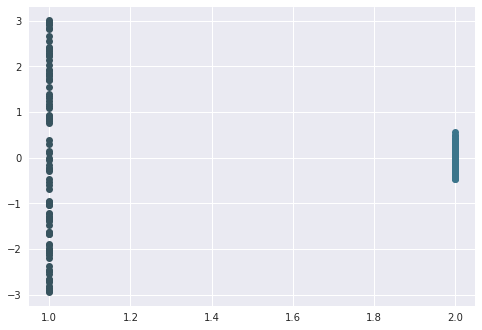

In [139]:

plt.plot([1]*100,np.sort(y-np.mean(y)),'o')
plt.plot([2]*100,np.sort(res1),'o')

### R-squared

R-squared (coefficient of determination) is a statistical measure of how close the data are to the fitted regression line. 
 It is the** percentage of the response variable variation that is explained by the linear model**.
 
 $$R^2 = \frac{ \text{Explained variation}}{ \text{Total variation}}= \frac{\sum_{i=1}^n  (\hat Y_i - \bar Y)^2}{\sum_{i=1}^n (Y_i - \bar Y)^2}
= 1 - \frac{\sum_{i=1}^n (Y_i - \hat Y_i)^2}{\sum_{i=1}^n (Y_i - \bar Y)^2}$$
 
$$ \text{Total variation} = \sum_{i=1}^n (Y_i - \bar Y)^2 
= \text{Explained variation} + \text{Residual variation}=  \sum_{i=1}^n (\hat Y_i - \bar Y)^2 +\sum_{i=1}^n (Y_i - \hat Y_i)^2$$

Estimate of residual variation arounfd the regression line, $\sigma^2$,
$$\hat \sigma^2 = \frac{1}{n-2}\sum_{i=1}^n e_i^2$$

* $R^2 $ is the percentage of the variation explained by the regression model.
* $0 \leq R^2 \leq 1$ (**higher** is better because more variance is explained by the model)
* $R^2$ can be misleading summary of model fit
 - Deleting data may inflate $R^2$
 - Adding terms to a regression model always increases $R^2$
 

In [134]:
coefofdet = regr.score(x_n.reshape(-1,1), y_n.reshape(-1,1))

print('sklearn R^2: ' + str(coefofdet))

sklearn R^2: 0.926819518483


In [147]:
print('statsmodel R^2: ' + str(model.rsquared))


statsmodel R^2: 0.926819518483


# Exercises:

* **Ground cricket chirps**
The following data shows the relationship between chirps per second of a striped ground cricket and the corresponding ground temperature (in ºF)
 *  Determine a linear regression model equation to represent this data.
 * Plot the data and the obtained equation.
 * Decide on the goodness of fit of the model.
 * Extrapolate:  If the ground temperature reached 95º, then at what approximate rate would you expect the crickets to be chirping?
 * Interpolate:  With a listening device, you discovered that on a particular morning the crickets were chirping at a rate of 18 chirps per second.  What was the approximate ground temperature that morning? 
 * 	If the ground temperature should drop to freezing (32º F), what happens to the cricket's chirping rate?
 

In [135]:
chirps_per_second = [20., 16., 19.8, 18.4, 17.1,15.5 ,14.7 ,15.7,15.4 ,16.3 ,15.0 ,17.2,
16.0 ,17.0 ,14.4 ]
temperature = [88.6,71.6,93.3,84.3,80.6,75.2,69.7,71.6,69.4,83.3,79.6,82.6,80.6,83.5,76.3]


* **Company data** We have a suspicion that in the dataset "company_data.csv" there is a relationship between x1 and y. We are interested in studying the magnitude of this relationship. Use a linear regression model to investigate this relationship. 
 Would you be confident telling that there is a meaningful relationship between x1 and y?



* For the following datasets  perform a linear regression and evaluate the goodness of fit with residual plots and $R^2$. Do you observe anything unusual?



In [136]:
x =  np.random.uniform(-3,3,100)
distribution = stats.norm(loc=0,scale=0.2)
y = np.sin(x) + x + distribution.rvs(size=100)

In [137]:
x =  np.random.uniform(0,6,100)
y = np.zeros(100)

for i in xrange(len(x)):
    
    distribution = stats.norm(loc=0,scale=0.001*x[i])
    y[i] = x[i] +  distribution.rvs(size=1)

* **Anscombe dataset **
 - Load 'anscombe' dataset from seaborn library.
 - You will notice that there are four different datasets each with different values of x and y. For every dataset create and store the data in a seperate dataframe and observe the summary of those
 - For each dataset, fit a linear regression model and print the intercept and the slope of the predicted model
 - Calculate the $R^2$ for each dataset.
 - Create residual plots.


## Appendix




| Element | Description|
|----|----|
| Dep. Variable 	| Which variable is the response in the model|
|Model |	What model you are using in the fit|
|Method |	How the parameters of the model were calculated 
|No. Observations 	|The number of observations (examples)
|DF Residuals |	Degrees of freedom of the residuals. Number of observations – number of parameters
|DF Model |	Number of parameters in the model (not including the constant term if present)

The right part of the first table shows the goodness of fit

|Element |	Description|
|----|----|
|R-squared 	|The coefficient of determination. A statistical measure of how well the regression line approximates the real data points|
|Adj. R-squared |	The above value adjusted based on the number of observations and the degrees-of-freedom of the residuals|
|F-statistic |	A measure how significant the fit is. The mean squared error of the model divided by the mean squared error of the residuals|
|Prob (F-statistic) |	The probability that you would get the above statistic, given the null hypothesis that they are unrelated|
|Log-likelihood |	The log of the likelihood function.|
|AIC 	|The Akaike Information Criterion. Adjusts the log-likelihood based on the number of observations and the complexity of the model.
|BIC |	The Bayesian Information Criterion. Similar to the AIC, but has a higher penalty for models with more parameters.|

The left part of the table reports for each of the coefficients

|Description|	Name of the term in the model|
|-----------|---------------------|
|coef |	The estimated value of the coefficient|
|std err |	The basic standard error of the estimate of the coefficient. More sophisticated errors are also available.|
|t 	|The t-statistic value. This is a measure of how statistically significant the coefficient is.|
|P > t |	P-value that the null-hypothesis that the coefficient = 0 is true. If it is less than the confidence level, often 0.05, it indicates that there is a statistically significant relationship between the term and the response.|

|Element 	|Description|
|-----------|---------------------|
|Skewness |	A measure of the symmetry of the data about the mean. Normally-distributed errors should be symmetrically distributed about the mean (equal amounts above and below the line).|
|Kurtosis |	A measure of the shape of the distribution. Compares the amount of data close to the mean with those far away from the mean (in the tails).|
|Omnibus |	D’Angostino’s test. It provides a combined statistical test for the presence of skewness and kurtosis.|
|Prob(Omnibus) |	The above statistic turned into a probability|
|Jarque-Bera |	A different test of the skewness and kurtosis|
|Prob (JB) 	|The above statistic turned into a probability|
|Durbin-Watson |	A test for the presence of autocorrelation (that the errors are not independent.) Often important in time-series analysis|
|Cond. No |	A test for multicollinearity (if in a fit with multiple parameters, the parameters are related with each other).|